In [128]:
#Importamos librerias utiles
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
#leemos nuestras imagenes de textura(serán 4):
tex1 = cv2.imread('texturas/D6.bmp',cv2.IMREAD_GRAYSCALE)
tex2 = cv2.imread('texturas/D64.bmp',cv2.IMREAD_GRAYSCALE)
tex3 = cv2.imread('texturas/D49.bmp',cv2.IMREAD_GRAYSCALE)
tex4 = cv2.imread('texturas/D101.bmp',cv2.IMREAD_GRAYSCALE)
#metemos las imagenes a una lista o bolsa de imagenes
bolsa = [tex1,tex2,tex3,tex4]

#Vemos las imagenes con el visor para tener una idea del tamaño de la ventana
for imagen in bolsa:
    cv2.imshow('Texturas',imagen)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Para tex1 Dado que los bloques son uniformes y alineados. Consideramos un tamaño de ventana de (128,128), considerando que la imagen tiene dimensiones de 640x640 pixeles entonces tendremos a lo largo y a lo ancho 5 ventanas.
Para tex2 tenemos un patron uniforme por lo que consideramos tamaño de la ventana de (107,84). Para este tamaño encontramos un periodo de la red simetrica. Dadas las dimensiones de la imagen y que queremos que se ajuste un numero entero de ventanas a lo largo y ancho de la red, entonces extendemos las dimensiones a (128,128).
Para tex3 debido a que no existe una periodicidad bidireccional, vamos a considerar un tamaño de (128,128).
En tex4 observamos una curvatura inherente a la imagen por lo que vamos a considerar un tamaño equivalente a nueve unidades de la imagen para asi evitar ruido debido a esta curvatura. Este tamaño equivale a una ventana de dimension (114,110). De nuevo debido a las dimensiones de la imagen, el tamaño de la ventana a considerar sera de (128,128).
Note que las redes de las imagenes son altamente periodicas y simetricas, por lo que consideramos que no existe una gran variacion en cuanto a los valores de intensidad y textura con respecto a los pixeles vecinos, es decir, unicamente tomaremos los valores de 25 ventanas para todos los casos

In [129]:
#probamos con la matriz de ejemplo del tutorial de texturas proporcionado por
#los profesores. El pdf puede encontrarse en la siguiente direccion:
#https://prism.ucalgary.ca/handle/1880/51900
#la prueba sirve para entender la funcion proporcionada por scikit-image
image = np.array([[0, 0, 1, 1],[0, 0, 1, 1],[0, 2, 2, 2],[2, 2, 3, 3]], dtype=np.uint8)
resultado = greycomatrix(image,distances=[1],angles=[0],levels=4,symmetric=True)
glcm = resultado[:,:,0,0]
print(glcm)
contraste = greycoprops(resultado,'contrast')
contraste[0][0]

[[4 2 1 0]
 [2 4 0 0]
 [1 0 6 1]
 [0 0 1 2]]


0.5833333333333333

La Documentacion de scikit image de la funcion greycopropos nos proporciona 6 propiedades de la imagen a partir de la matriz GCLM. Estas seis propiedades son: Contraste, disimilitud, homogeneidad, ASM, energia y correlacion. Una imagen de la misma documentacion se muestra a continuacion.
![props.PNG](attachment:props.PNG)

In [130]:
#Dado que forzamos que las ventanas entren en las imagenes (es decir evitamos algun tipo
#de overflow) simplemente debemos hacer dos ciclos for que iteren sobre la imagen
#de acuerdo al tamaño de la ventana y para cada iteracion calcular la matriz GCLM
#para asi obetener los valores deseados y guardarlos en un array.

#Primero creamos un array donde almacenaremos los valores, segun el tamaño de la ventana.
#Las dimensiones del array son (4,6,25), 4 porque cada dimension corresponderá a una imagen de textura
#6 porque son 6propiedades y 25 ya que recorreremos la ventana 25 veces (cubriremos la imagen con 25 ventanas)
propiedades = np.zeros((4,25,6),dtype=float)

#creamos una variable auxiliar para contar las imagenes analizadas en el ciclo for
contadorImagen = 0
#creamos los ciclos de iteracion
#iteramos sobre todas las imagenes
for imagen in bolsa:
    contadorVentana = 0
    #iteramos sobre las filas ponemos el centro de la ventana inicial en imagen.shape[0]/10 = 64
    #hasta llegar a 640 con paso imagen.shape[0]/5=128 que es donde se pondran los centros de la
    #imagen
    for filas in range(64,640,128):
        #iteramos sobre las columnas ponemos el centro de la ventana inicial en imagen.shape[0]/10 = 64
    #hasta llegar a 640 con paso imagen.shape[0]/5=128 que es donde se pondran los centros de la
    #imagen
        for columnas in range(64,640,128):
            ventana = imagen[filas-64:filas+65,columnas-64:columnas+65]
            GLCM = greycomatrix(ventana,distances=[1],angles=[0],symmetric=True)
            contraste = greycoprops(GLCM,'contrast')
            disimilitud = greycoprops(GLCM,'dissimilarity')
            homogeneidad = greycoprops(GLCM,'homogeneity')
            asm = greycoprops(GLCM,'ASM')
            energia = greycoprops(GLCM,'energy')
            correlacion = greycoprops(GLCM,'correlation')
            propiedades[contadorImagen,contadorVentana]=(contraste,disimilitud,homogeneidad,asm,energia,correlacion)
            contadorVentana+=1
    contadorImagen+=1

In [131]:
#creamos cuatro data frames (uno por cada imagen) con las propiedades que obtuvimos previamente
#esto se hace por si se desea guardar la informacion en archivos csv, txt, data etc.
textura1 = pd.DataFrame(propiedades[0])
textura2 = pd.DataFrame(propiedades[1])
textura3 = pd.DataFrame(propiedades[2])
textura4 = pd.DataFrame(propiedades[3])

#renombramos los nombres de las columnas de cada Df:
textura1.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
textura2.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
textura3.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
textura4.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)

In [132]:
#apartir de aqui ya tenemos nuestros vectores de atributos X o variables independientes. Hay que agregar las variables 
#dependientes Y. Dado que tenemos 5 clases o categorias tenemos que hacer 5 vectores de dimension (25,1) para
#cada clase y entrenaremos primero un clasificador Bayesiano ingenuo categorico. La dimension de 25 es porque
#tenemos 25 datos de cada clase. Asignaremos valor 1 a la imagen tex1, 2 a la tex2, etc
yTex1 = np.ones((propiedades[0].shape[0]),dtype=int)
yTex2 = 2*np.ones((propiedades[1].shape[0]),dtype=int)
yTex3 = 3*np.ones((propiedades[2].shape[0]),dtype=int)
yTex4 = 4*np.ones((propiedades[3].shape[0]),dtype=int)

#creamos una nueva columna para cada dataframe llamada clase y en dicha columna ponemos el valor de la clase
textura1['Clase'] = yTex1
textura2['Clase'] = yTex2
textura3['Clase'] = yTex3
textura4['Clase'] = yTex4

#creamos un nuevo Dataframe que contendra los 4 df.
Datos = pd.concat([textura1,textura2,textura3,textura4],ignore_index=True)
Datos.head(5)

,Contraste,Disimilitud,Homegeneidad,ASM,Energia,Correlacion,Clase
0,1958.984012,23.753513,0.184362,0.003874,0.062245,0.492462,1
1,1482.354227,19.447614,0.253226,0.010354,0.101755,0.471638,1
2,1509.096294,19.555596,0.250687,0.010210,0.101043,0.472033,1
3,1342.573765,18.466691,0.258279,0.011055,0.105141,0.474136,1
4,1372.338705,18.873650,0.242536,0.008660,0.093058,0.487630,1


In [133]:
#definimos nuestros conjuntos de entrenamiento de acuerdo a el df Datos
xTrain = (Datos.drop(columns=['Clase'])).to_numpy()
yTrain = (Datos['Clase']).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes
categoricaBayes = CategoricalNB()
categoricaBayes.fit(xTrain,yTrain)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [134]:
#Validacion cruazada. Este metodo no se usa ya que no supe como ajustar los parametros que provee
#la validacion cruzada
maquinaSoporte = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(maquinaSoporte, xTrain, yTrain, cv=5)
predicted = cross_val_predict(maquinaSoporte, xTrain, yTrain, cv=5)
predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [135]:
#Esta parte tambien es para la validacion cruzada de K particiones, pero no se uso por el mismo problema 
#comentado en la celda anterior
#Instanciamos una clase de SuffleSplit con 5 particiones, 20% de datos para test y una semilla para que 
#obtener resultados reproducibles
rs = ShuffleSplit(n_splits=5, test_size=.20, random_state=0)
#creamos un entero auxiliar que nos ayudara a guardar los parametros en un array
cont = 6
#creamos un array que contendra los parametros de cada particion. Por defecto, un entrenamiento
#de svm va a dar un array de 6,6 con los parametros
parametros = np.zeros((30,6),dtype=float)
#para cada particion creada por la clase ShuffleSplit
for train_index, test_index in rs.split(xTrain):
    #define el modelo SVC de suport machine vector de sckitlear y llamalo mm
    mm = svm.SVC(kernel='linear', C=1)
    #entrena con los datos de entrenamiento cuyo indice corresponde a los indices de entrenamiento
    #dados por la clase Shuffle
    mm.fit(xTrain[train_index],yTrain[train_index])
    #define una variable j que contendra las predicciones de cada iteracion, con los indices de test
    j = mm.predict(xTrain[test_index])
    #imprime el accurracy score de yTrain y j, note que deben ser los mismos indices para el caso de la
    #prediccion y yTrain 
    print(accuracy_score(yTrain[test_index], j))
    #guarda en la matriz de parametros, los parametros arrojados por el SVC
    parametros[cont-6:cont,:]=mm.coef_
    #incrementa iterativamente el entero auxiliar
    cont+=6

1.0
1.0
1.0
1.0
1.0


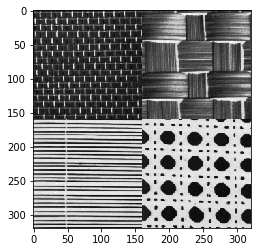

In [136]:
#Leemos nuestra imagen de preuba y la mostramos 
prueba = cv2.imread('texturas/imgCompuesta1.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(prueba,cmap='gray')
plt.show()

In [137]:
#creamos un array del mismo tamaño de la imagen de prueba del tipo uint8 (escala de gris), una para
#Naive y otra para SVM (N para naive)
imagenvalidadaN = np.zeros((prueba.shape),dtype=np.uint8)
imagenvalidadaS = np.zeros((prueba.shape),dtype=np.uint8)
#creamos un array de 1 fila 6 columnas para almacenar temporalmente las propiedades obtenidas para cada ventana
#con estas propiedades vamos a usar los modelos Naive y SVM para clasificar y/o predecir a que clase pertenece
propiedades1=np.zeros((1,6),dtype=float)
#iteramos sobre las filas con centro en 20 hasta 320 con paso 40
for filas in range(20,320,40):
    #iteramos sobre las columnas con centro en 20 hasta 320 con paso 40
    for columnas in range(20,320,40):
        #dados los valores de filas y columnas recorremos la ventana, el valor de la ventana sera un array con
        #dimensiones 40x40 y sus valores seran unicamente los que corresponden a la imagen original en la posicion
        #de la ventana
        ventana = prueba[filas-20:filas+21,columnas-20:columnas+21]
        #redefinimos nuestra matriz GLCM para calcular las propiedades de los valores de la ventana y asi
        #poder clasificar
        GLCM = greycomatrix(ventana,distances=[1],angles=[0],symmetric=True)
        #calculamos contraste a partir de la GLCM
        contraste = greycoprops(GLCM,'contrast')
        #calculamos disimulitud a partir de la GLCM
        disimilitud = greycoprops(GLCM,'dissimilarity')
        #calculamos homogeneidad a partir de la GLCM
        homogeneidad = greycoprops(GLCM,'homogeneity')
        #calculamos ASM a partir de la GLCM
        asm = greycoprops(GLCM,'ASM')
        #calculamos energia a partir de la GLCM
        energia = greycoprops(GLCM,'energy')
        #calculamos correlacion a partir de la GLCM
        correlacion = greycoprops(GLCM,'correlation')
        #rellenamos nuestra matriz (vector de propiedades) definida previamente con los valores que acabamos de calcular
        propiedades1[0,:] =(contraste[0][0],disimilitud[0][0],homogeneidad[0][0],asm[0][0],energia[0][0],correlacion[0][0])
        #predecimos con SVM
        prediS = mm.predict(propiedades1)
        #predecimos con Naive
        prediN = categoricaBayes.predict(propiedades1)
        #si la prediccion con Naive fue 1 entonces rellenamos a la imagen validada con ceros, en la posicion en la
        #que se encuentre nuestra ventana
        if prediN[0] == 1:
            imagenvalidadaN[filas-20:filas+21,columnas-20:columnas+21] = 0
        #si la prediccion con Naive fue 2 entonces rellenamos a la imagen validada con 63, en la posicion en la
        #que se encuentre nuestra ventana
        elif prediN[0] == 2:
            imagenvalidadaN[filas-20:filas+21,columnas-20:columnas+21] = 63
        #si la prediccion con Naive fue 3 entonces rellenamos a la imagen validada con 127, en la posicion en la
        #que se encuentre nuestra ventana
        elif prediN[0] == 3:
            imagenvalidadaN[filas-20:filas+21,columnas-20:columnas+21] = 127
        #si la prediccion con Naive fue 4 entonces rellenamos a la imagen validada con 255, en la posicion en la
        #que se encuentre nuestra ventana
        elif prediN[0]==4:
            imagenvalidadaN[filas-20:filas+21,columnas-20:columnas+21] = 255
        #si la prediccion con SVM fue 1 entonces rellenamos a la imagen validada con ceros, en la posicion en la
        #que se encuentre nuestra ventana
        if prediS[0] == 1:
            imagenvalidadaS[filas-20:filas+21,columnas-20:columnas+21] = 0
        #si la prediccion con SVM fue 2 entonces rellenamos a la imagen validada con 63, en la posicion en la
        #que se encuentre nuestra ventana
        elif prediS[0] == 2:
            imagenvalidadaS[filas-20:filas+21,columnas-20:columnas+21] = 63
        #si la prediccion con SVM fue 3 entonces rellenamos a la imagen validada con 127, en la posicion en la
        #que se encuentre nuestra ventana
        elif prediS[0] == 3:
            imagenvalidadaS[filas-20:filas+21,columnas-20:columnas+21] = 127
        #si la prediccion con SVM fue 4 entonces rellenamos a la imagen validada con 255, en la posicion en la
        #que se encuentre nuestra ventana
        elif prediS[0]==4:
            imagenvalidadaS[filas-20:filas+21,columnas-20:columnas+21] = 255

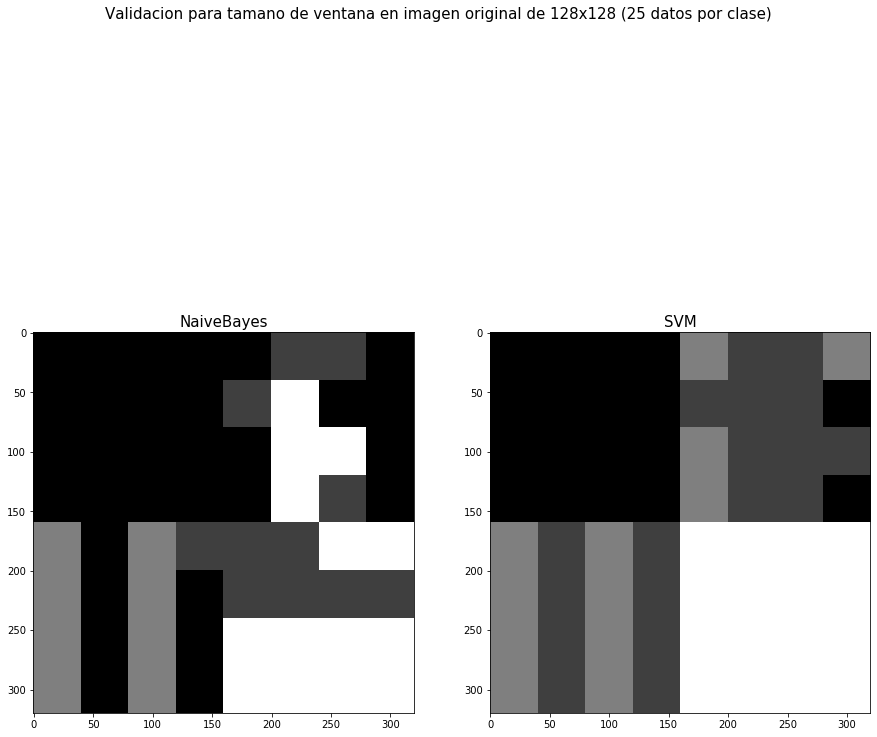

In [138]:
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 128x128 (25 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(imagenvalidadaN,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(imagenvalidadaS,cmap='gray')
plt.show()

## Apartir de aqui es inverosimil repetir codigo asi que decidi crear funciones para limitar un poco el codigo. Si bien es cierto las funciones no generalizan todo el codigo si nos ahorra unas cuantas lineas

In [139]:
#funcion para obtener las caracteristicas de la GLCM dada una imagen y un tamaño de ventana (solo funciona para imagenes cuadradas)
def caracteristicas(tamano,Imagen):
    #definimos matriz que contendra las propiedades. las dimensiones dependen del tamano de la imagen y el tamano de la ventana
    #son seis columnas porque solo se obtienen 6 carcateristicas de la GLCM
    propiedades = np.zeros((round(Imagen.shape[0]/tamano)**2,6),dtype=float)
    #valor auxiliar que nos ayuda a contar en que ventana estamos 0 al inicio, 1 a la siguiente, 2 a la siguiente etc
    contadorVentana = 0
    #calculamos el centro de la ventana depende del tamaño dado de la ventana dividido por dos
    centro = round(tamano/2)
    #iteramos sobre las filas comenzando desde el centro hasta el tamaño de la imagen con paso tamaño de la ventana
    for filas in range(centro,Imagen.shape[0],tamano):
        #iteramos sobre las columnas comenzando desde el centro hasta el tamaño de la imagen con paso tamaño de la ventana
        for columnas in range(centro,Imagen.shape[0],tamano):
            #dados los valores de filas y columnas recorremos la ventana, el valor de la ventana sera un array con
            #dimensiones filasxcolumnas y sus valores seran unicamente los que corresponden a la imagen dada en la posicion
            #de la ventana
            ventana = Imagen[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)]
            #definimos la GLCM a partir del array ventana, considera distancia 1 de cada pixel dentro de la ventana y angulo cero
            GLCM = greycomatrix(ventana,distances=[1],angles=[0],symmetric=True)
            #calculamos las propiedades a partir de la GLCM
            contraste = greycoprops(GLCM,'contrast')
            disimilitud = greycoprops(GLCM,'dissimilarity')
            homogeneidad = greycoprops(GLCM,'homogeneity')
            asm = greycoprops(GLCM,'ASM')
            energia = greycoprops(GLCM,'energy')
            correlacion = greycoprops(GLCM,'correlation')
            #guardamos en la matriz propiedades en la fila contadorVentana los valores que calculamos de las propiedades
            propiedades[contadorVentana]=(contraste,disimilitud,homogeneidad,asm,energia,correlacion)
            #incrementa iterativamente el valor de contadorVentana en 1
            contadorVentana+=1
    #Al terminar regresa la matriz propiedades
    return propiedades

In [140]:
#calculamos las propiedades de la GLCM para cada imagen de textura ahora con un tamaño de ventana de 64 y los guardamos en
#la variable cnumero segun el numero de la textura
c1 = caracteristicas(64,tex1)
c2 = caracteristicas(64,tex2)
c3 = caracteristicas(64,tex3)
c4 = caracteristicas(64,tex4)

In [141]:
#creamos el vector que contendra las clases: textura 1 clase 1 y asi sucesivamente
y1 = np.ones((c1.shape[0]),dtype=int)
y2 = 2*np.ones((c2.shape[0]),dtype=int)
y3 = 3*np.ones((c3.shape[0]),dtype=int)
y4 = 4*np.ones((c4.shape[0]),dtype=int)
#Creamos 4 df con las caracteristicas
t1 = pd.DataFrame(c1)
t2 = pd.DataFrame(c2)
t3 = pd.DataFrame(c3)
t4 = pd.DataFrame(c4)
#renombramos los nombres de las columnas de cada Df:
t1.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
t2.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
t3.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
t4.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
#creamos una nueva columna para cada dataframe llamada clase y en dicha columna ponemos el valor de la clase
t1['Clase'] = y1
t2['Clase'] = y2
t3['Clase'] = y3
t4['Clase'] = y4

#creamos un nuevo Dataframe que contendra los 4 df y lo llamamos D de Datos.
D = pd.concat([t1,t2,t3,t4],ignore_index=True)
#definimos nuestros conjuntos de entrenamiento de acuerdo a el df D
xT = (D.drop(columns=['Clase'])).to_numpy()
yT = (D['Clase']).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los datos recien obtenidos
categorica = CategoricalNB()
categorica.fit(xT,yT)
#ya teniamos una SVM que no habiamos entrenado, entonces la usamos para entrenar con estos nuevos datos
maquinaSoporte.fit(xT,yT)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
#funcion para validacion que come un tamaño de ventana para validar, la imagen a validar y el modelo que va a hacer prediccion
def validacion(tamano, Imagen, modelo):
    #creamos la imagen de validacion de las mismas dimensiones que la imagen de entrada
    imagenValidada = np.zeros((Imagen.shape),dtype=np.uint8)
    #creamos un array de 1 fila 6 columnas para almacenar temporalmente las propiedades obtenidas para cada ventana
    #con estas propiedades vamos a usar el modelo de entrada para clasificar y/o predecir a que clase pertenece
    propiedades = np.zeros((1,6), dtype=float)
    #calculamos el centro de la ventana que depende del mismo tamaño de ventana
    centro = round(tamano/2)
    #iteramos sobre las filas con centro hasta el tamaño de la imagen con paso tamano
    for filas in range(centro,Imagen.shape[0],tamano):
        #iteramos sobre las columnas con centro hasta el tamaño de la imagen con paso tamano
        for columnas in range(centro,Imagen.shape[0],tamano):
            #dados los valores de filas y columnas recorremos la ventana, el valor de la ventana sera un array con
            #dimensiones filasxcolumnas y sus valores seran unicamente los que corresponden a la imagen dada en la posicion
            #de la ventana
            ventana = Imagen[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)]
            #definimos la GLCM a partir del array ventana, considera distancia 1 de cada pixel dentro de la ventana y angulo cero
            GLCM = greycomatrix(ventana,distances=[1],angles=[0],symmetric=True)
            #calculamos las propiedades a partir de la GLCM
            contraste = greycoprops(GLCM,'contrast')
            disimilitud = greycoprops(GLCM,'dissimilarity')
            homogeneidad = greycoprops(GLCM,'homogeneity')
            asm = greycoprops(GLCM,'ASM')
            energia = greycoprops(GLCM,'energy')
            correlacion = greycoprops(GLCM,'correlation')
            #rellenamos nuestra matriz (vector de propiedades) definida previamente con los valores que acabamos de calcular
            propiedades[0,:] =(contraste[0][0],disimilitud[0][0],homogeneidad[0][0],asm[0][0],energia[0][0],correlacion[0][0])
            #definimos la prediccion como la prediccion del modelo usando el array de propiedades recien calculado
            prediccion = modelo.predict(propiedades)
            #Si la prediccion dice que es clase 1, entonces rellenamos a la imagen validada con ceros, en la posicion en la
            #que se encuentre nuestra ventana
            if prediccion[0] == 1:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 0
            #si la prediccion fue 2 entonces rellenamos a la imagen validada con 63, en la posicion en la
            #que se encuentre nuestra ventana
            elif prediccion[0] == 2:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 63
            #si la prediccion fue 3 entonces rellenamos a la imagen validada con 127, en la posicion en la
            #que se encuentre nuestra ventana
            elif prediccion[0] == 3:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 127
            #si la prediccion fue 4 entonces rellenamos a la imagen validada con 127, en la posicion en la
            #que se encuentre nuestra ventana
            else:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 255
    #regresamos la imagen validada
    return imagenValidada

In [143]:
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM = validacion(40,prueba,maquinaSoporte)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay = validacion(40,prueba,categorica)

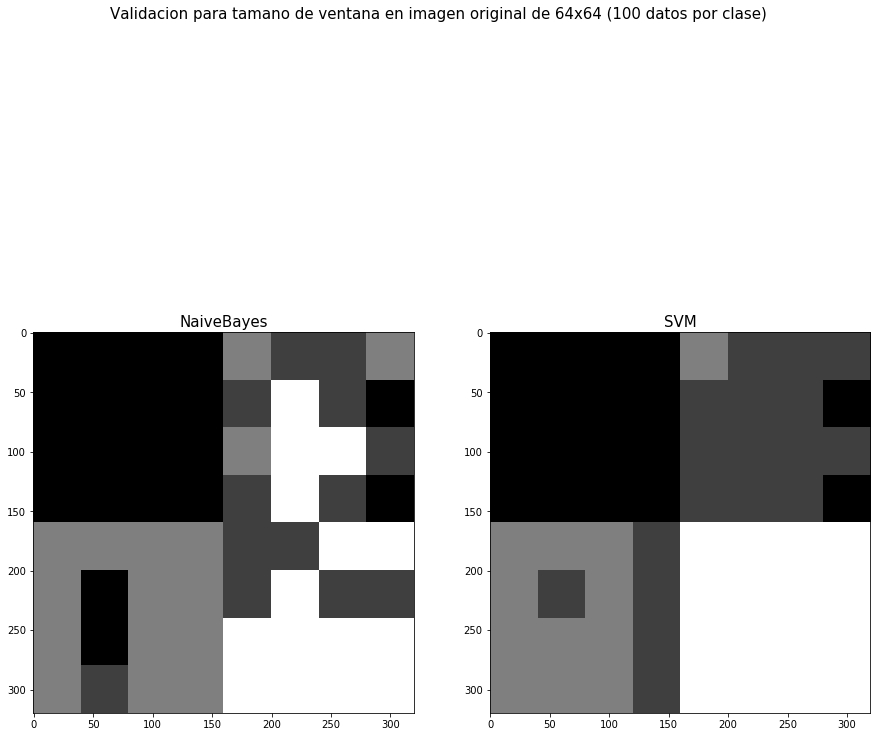

In [144]:
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM,cmap='gray')
plt.show()

## Visualmente el hecho de agregar mas datos proporciona un mejor resultado para ambos casos. Sin embargo el hecho de agregar una infinidad de datos no garantiza que obtendremos los mejores resultados. Entonces lo que vamos a hacer es una seleccion de caracteristicas. A primera vista los valores de contraste y disimilitud son mayores que 10 mientras que los otros son menores que 1 por lo que esto puede estar afectando los ajustes. Podria hacerse regularizacion de los datos, sin embargo la implentacion en la validacion sera laboriosa. De esta forma vamos a quitar dichos valores y ver que pasa. Para esto usamos el dataframe D.

In [145]:
#funcion para validacion que come un tamaño de ventana para validar, la imagen a validar y el modelo que va a hacer prediccion
def validacion1(tamano, Imagen, modelo,inicio,fin):
    #creamos la imagen de validacion de las mismas dimensiones que la imagen de entrada
    imagenValidada = np.zeros((Imagen.shape),dtype=np.uint8)
    #creamos un array de 1 fila 6 columnas para almacenar temporalmente las propiedades obtenidas para cada ventana
    #con estas propiedades vamos a usar el modelo de entrada para clasificar y/o predecir a que clase pertenece
    propiedades = np.zeros((1,6), dtype=float)
    #calculamos el centro de la ventana que depende del mismo tamaño de ventana
    centro = round(tamano/2)
    #iteramos sobre las filas con centro hasta el tamaño de la imagen con paso tamano
    for filas in range(centro,Imagen.shape[0],tamano):
        #iteramos sobre las columnas con centro hasta el tamaño de la imagen con paso tamano
        for columnas in range(centro,Imagen.shape[0],tamano):
            #dados los valores de filas y columnas recorremos la ventana, el valor de la ventana sera un array con
            #dimensiones filasxcolumnas y sus valores seran unicamente los que corresponden a la imagen dada en la posicion
            #de la ventana
            ventana = Imagen[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)]
            #definimos la GLCM a partir del array ventana, considera distancia 1 de cada pixel dentro de la ventana y angulo cero
            GLCM = greycomatrix(ventana,distances=[1],angles=[0],symmetric=True)
            #calculamos las propiedades a partir de la GLCM
            contraste = greycoprops(GLCM,'contrast')
            disimilitud = greycoprops(GLCM,'dissimilarity')
            homogeneidad = greycoprops(GLCM,'homogeneity')
            asm = greycoprops(GLCM,'ASM')
            energia = greycoprops(GLCM,'energy')
            correlacion = greycoprops(GLCM,'correlation')
            #rellenamos nuestra matriz (vector de propiedades) definida previamente con los valores que acabamos de calcular
            propiedades[0,:] =(contraste[0][0],disimilitud[0][0],homogeneidad[0][0],asm[0][0],energia[0][0],correlacion[0][0])
            #definimos la prediccion como la prediccion del modelo usando el array de propiedades recien calculado
            prediccion = modelo.predict(propiedades[:,inicio:fin])
            #Si la prediccion dice que es clase 1, entonces rellenamos a la imagen validada con ceros, en la posicion en la
            #que se encuentre nuestra ventana
            if prediccion[0] == 1:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 0
            #si la prediccion fue 2 entonces rellenamos a la imagen validada con 63, en la posicion en la
            #que se encuentre nuestra ventana
            elif prediccion[0] == 2:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 63
            #si la prediccion fue 3 entonces rellenamos a la imagen validada con 127, en la posicion en la
            #que se encuentre nuestra ventana
            elif prediccion[0] == 3:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 127
            #si la prediccion fue 4 entonces rellenamos a la imagen validada con 127, en la posicion en la
            #que se encuentre nuestra ventana
            else:
                imagenValidada[filas-centro:filas+(centro+1),columnas-centro:columnas+(centro+1)] = 255
    #regresamos la imagen validada
    return imagenValidada

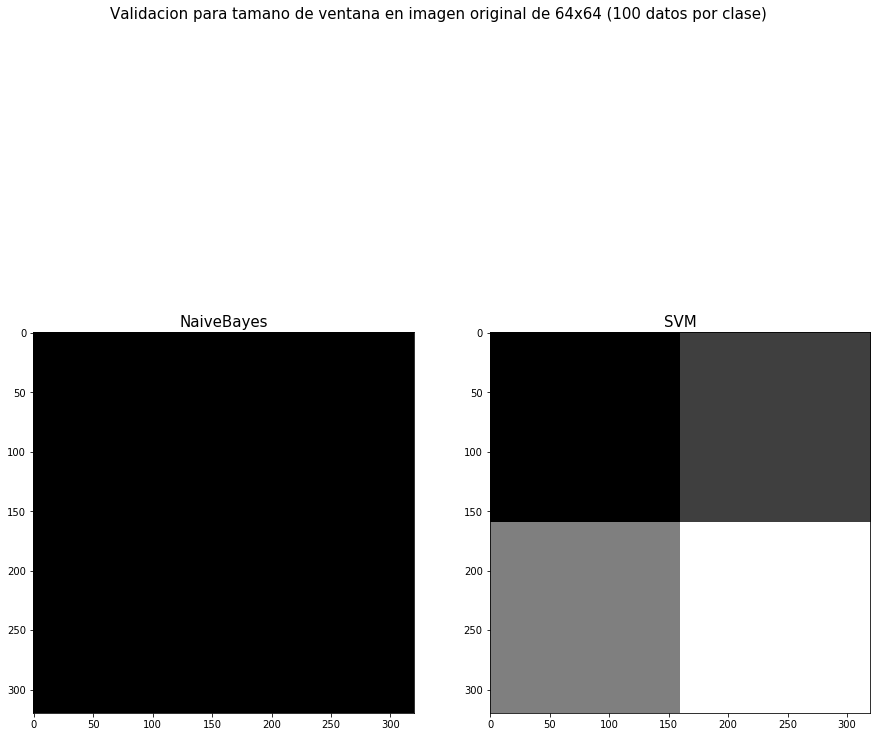

In [146]:
x =  (D.drop(columns=['Contraste','Disimilitud','Clase'])).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los nuevos
categorica1 = CategoricalNB()
categorica1.fit(x,yT)
#Definimos y entrenamos con los nuevos datos
maquinaSoporte1 = svm.SVC(kernel='linear', C=1)
maquinaSoporte1.fit(x,yT)
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM1 = validacion1(40,prueba,maquinaSoporte1,2,6)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay1 = validacion1(40,prueba,categorica1,2,6)
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay1,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM1,cmap='gray')
plt.show()


## Vemos que el SVM ofrece los resultados deseados, mientras que el Naive hace muy mal la clasificacion. ¿Qué pasa cuando cambiamos los parametros?

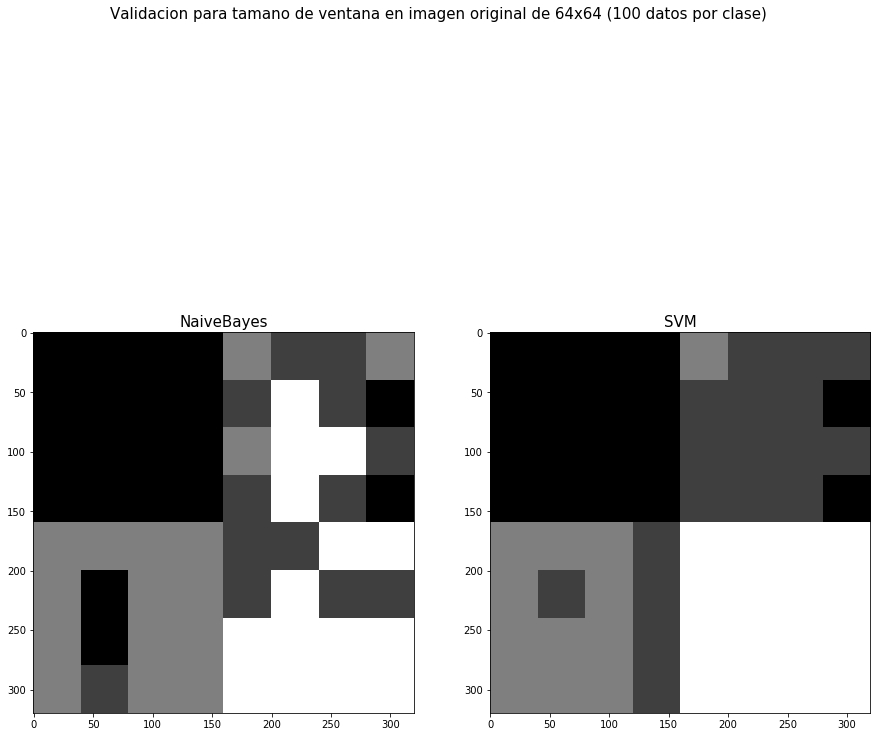

In [147]:
x2 =  (D.drop(columns=['Correlacion','Energia','Clase'])).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los nuevos
categorica2 = CategoricalNB()
categorica2.fit(x2,yT)
#Definimos y entrenamos con los nuevos datos
maquinaSoporte2 = svm.SVC(kernel='linear', C=1)
maquinaSoporte2.fit(x2,yT)
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM2 = validacion1(40,prueba,maquinaSoporte2,0,4)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay2 = validacion1(40,prueba,categorica2,0,4)
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay2,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM2,cmap='gray')
plt.show()

## Entrenemos ahora por pares tripletas

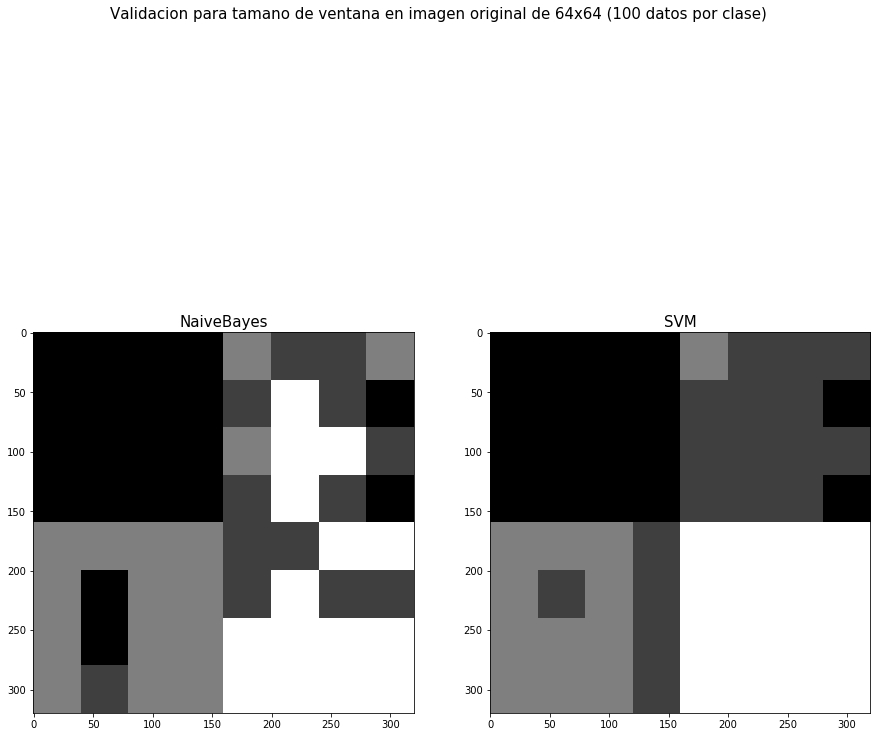

In [148]:
x3 =  (D.drop(columns=['Energia','ASM','Correlacion','Clase'])).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los nuevos
categorica3 = CategoricalNB()
categorica3.fit(x3,yT)
#Definimos y entrenamos con los nuevos datos
maquinaSoporte3 = svm.SVC(kernel='linear', C=1)
maquinaSoporte3.fit(x3,yT)
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM3 = validacion1(40,prueba,maquinaSoporte3,0,3)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay3 = validacion1(40,prueba,categorica3,0,3)
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay3,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM3,cmap='gray')
plt.show()

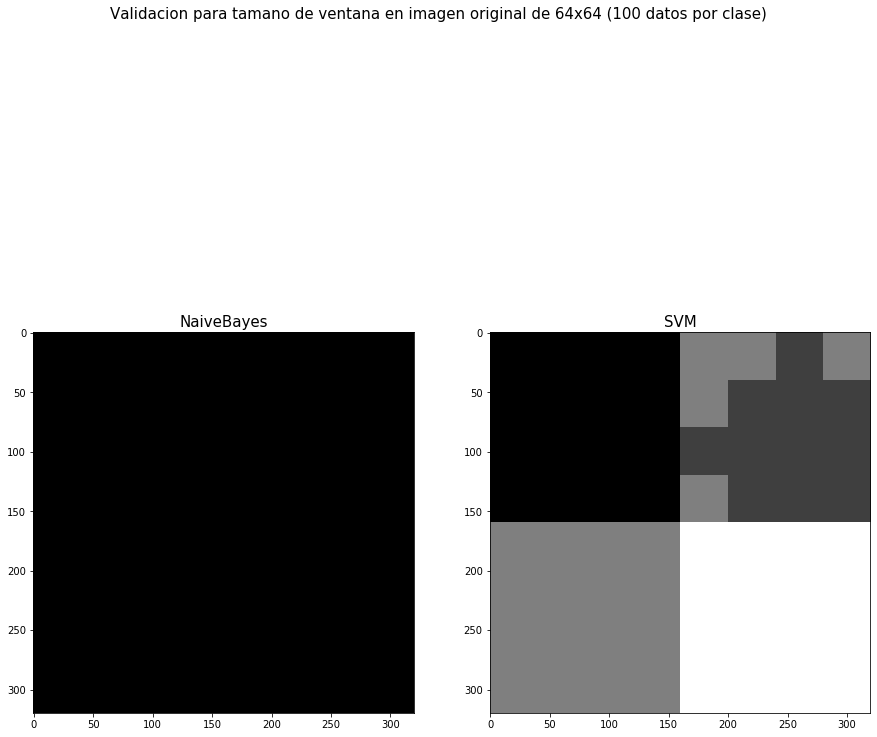

In [149]:
x4 =  (D.drop(columns=['Contraste','Disimilitud','Homegeneidad','Clase'])).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los nuevos
categorica4 = CategoricalNB()
categorica4.fit(x4,yT)
#Definimos y entrenamos con los nuevos datos
maquinaSoporte4 = svm.SVC(kernel='linear', C=1)
maquinaSoporte4.fit(x4,yT)
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM4 = validacion1(40,prueba,maquinaSoporte4,3,6)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay4 = validacion1(40,prueba,categorica4,3,6)
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay4,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM4,cmap='gray')
plt.show()

## Entrenemos por pares

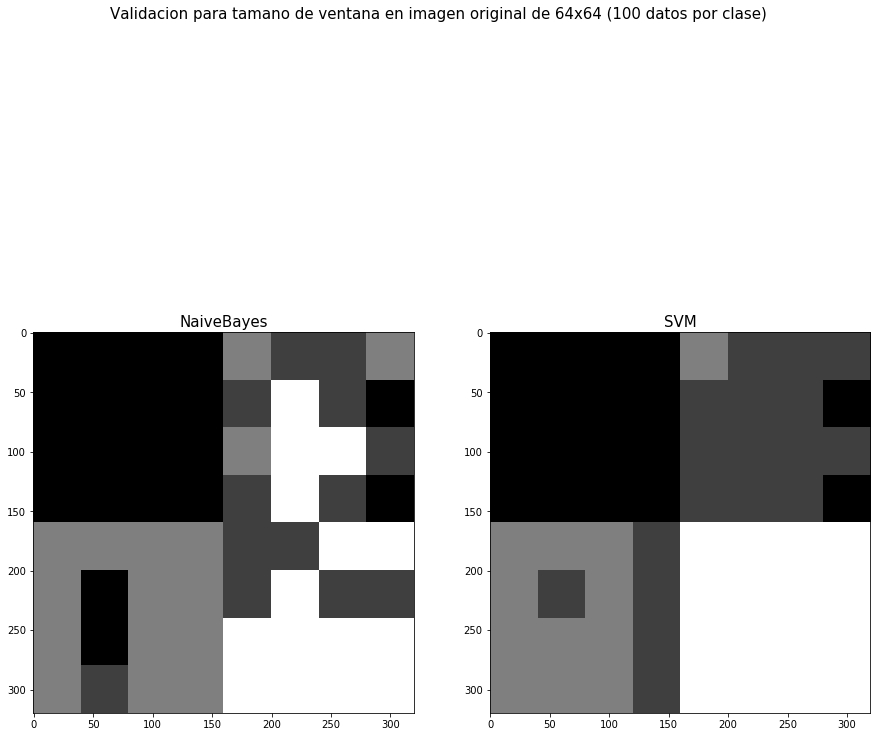

In [150]:
x5 =  (D.drop(columns=['Energia','ASM','Homegeneidad','Correlacion','Clase'])).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los nuevos
categorica5 = CategoricalNB()
categorica5.fit(x5,yT)
#Definimos y entrenamos con los nuevos datos
maquinaSoporte5 = svm.SVC(kernel='linear', C=1)
maquinaSoporte5.fit(x5,yT)
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM5 = validacion1(40,prueba,maquinaSoporte5,0,2)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay5 = validacion1(40,prueba,categorica5,0,2)
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay5,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM5,cmap='gray')
plt.show()

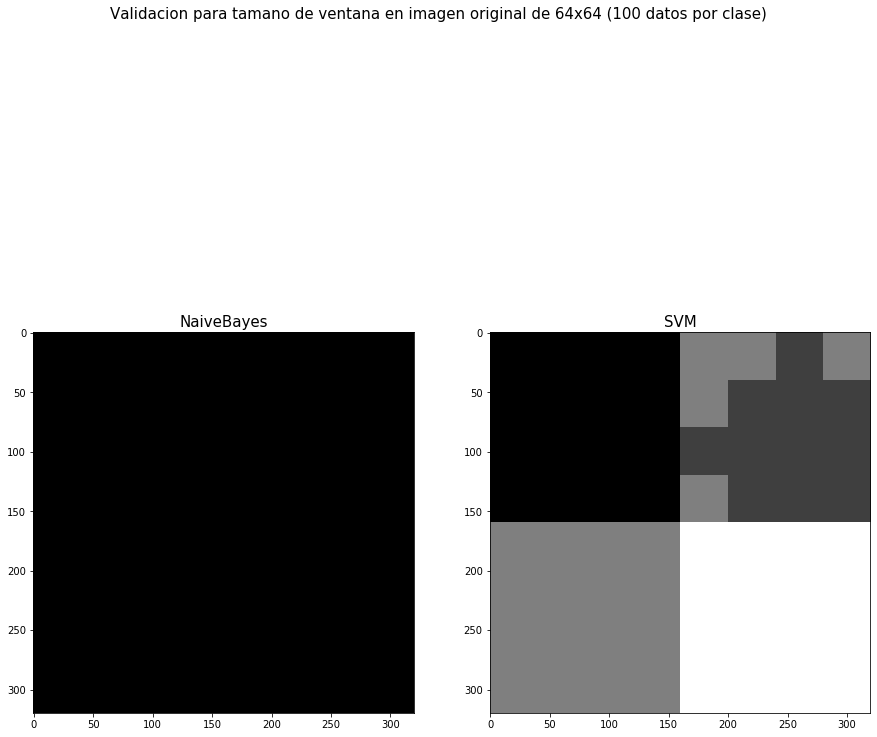

In [151]:
x6 =  (D.drop(columns=['Contraste','ASM','Homegeneidad','Disimilitud','Clase'])).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los nuevos
categorica6 = CategoricalNB()
categorica6.fit(x6,yT)
#Definimos y entrenamos con los nuevos datos
maquinaSoporte6 = svm.SVC(kernel='linear', C=1)
maquinaSoporte6.fit(x6,yT)
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM6 = validacion1(40,prueba,maquinaSoporte6,4,6)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay6 = validacion1(40,prueba,categorica6,4,6)
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay6,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM6,cmap='gray')
plt.show()

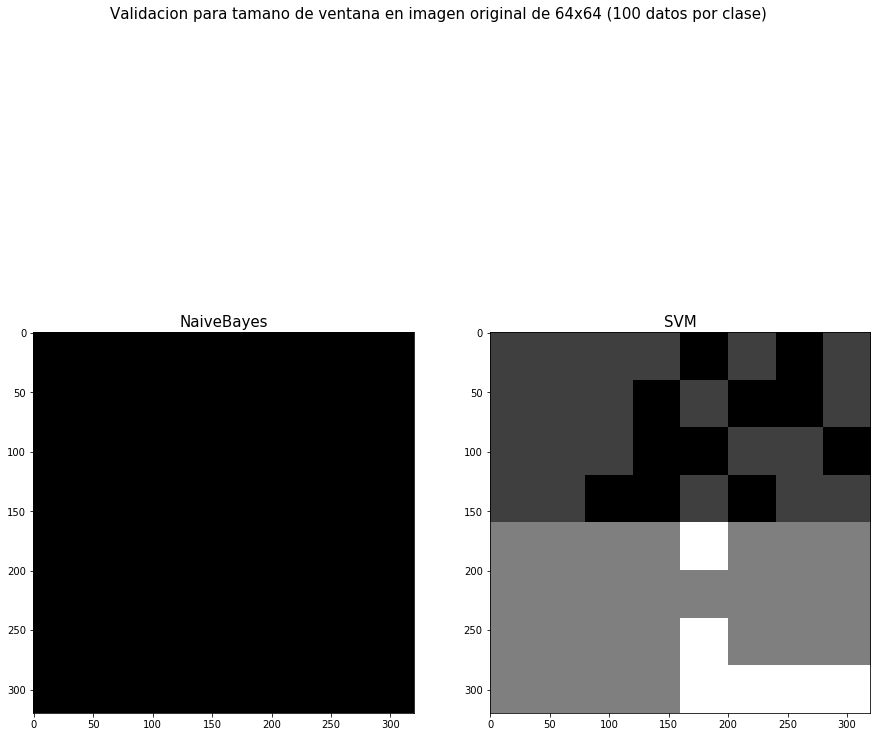

In [152]:
x7 =  (D.drop(columns=['Contraste','Correlacion','Energia','Disimilitud','Clase'])).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes con los nuevos
categorica7 = CategoricalNB()
categorica7.fit(x7,yT)
#Definimos y entrenamos con los nuevos datos
maquinaSoporte7 = svm.SVC(kernel='linear', C=1)
maquinaSoporte7.fit(x7,yT)
#validamos con SVM nuestra imagen de prueba, con tamano de ventana de 40x40
ImagenSVM7 = validacion1(40,prueba,maquinaSoporte7,2,4)
#validamos con Bayes nuestra imagen de prueba con tamano de ventana de 40x40
ImagenBay7 = validacion1(40,prueba,categorica7,2,4)
#graficamos ambas imagenes que acabamos de obtener con todo y descripcion
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('NaiveBayes',fontsize=15)
axarr[0].imshow(ImagenBay7,cmap='gray')
axarr[1].set_title('SVM',fontsize=15)
axarr[1].imshow(ImagenSVM7,cmap='gray')
plt.show()

De los dos entrenamientos previos vemos que los parametros contraste y Disimilitud tienen un gran peso como para dejar de lado las otras caracteristicas. Ahora entrenemos con solo dos atributos

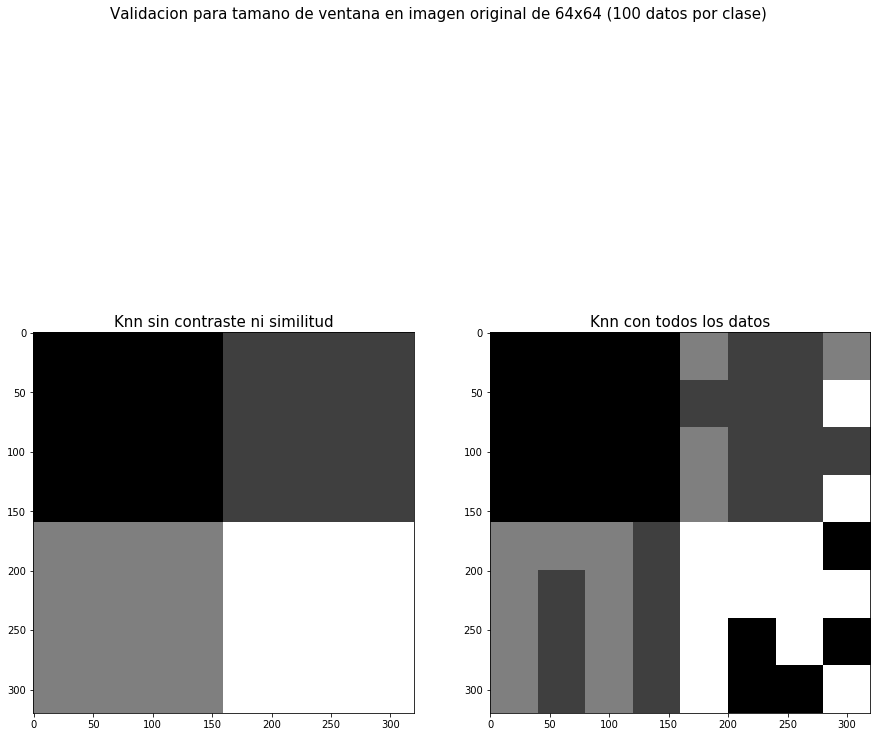

In [153]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(x, yT)
neigh1 = KNeighborsClassifier()
neigh1.fit(xT, yT)
ImagenKnn = validacion1(40,prueba,neigh,2,6)
ImagenKnn1 = validacion1(40,prueba,neigh1,0,6)
f, axarr = plt.subplots(1,2,figsize=(15,15)) 
f.suptitle('Validacion para tamano de ventana en imagen original de 64x64 (100 datos por clase)', fontsize=15)
axarr[0].set_title('Knn sin contraste ni similitud',fontsize=15)
axarr[0].imshow(ImagenKnn,cmap='gray')
axarr[1].set_title('Knn con todos los datos',fontsize=15)
axarr[1].imshow(ImagenKnn1,cmap='gray')
plt.show()